# Objective Tuner

This notebook evaluates different objective functions for the agent, visualizing them.

## Imports

See that we can access our code as we use it in the experiments. Add `../src` to our PYTHONPATH for this.

In [1]:
import os
import os.path
import pathlib
import graphviz

In [26]:
NOTEBOOK_DIR = pathlib.Path(os.path.abspath(os.curdir))

In [27]:
sys.path.insert(0, str(pathlib.Path(os.path.abspath(NOTEBOOK_DIR / ".." / "src"))))

In [28]:
import attack_paper.objective

In [29]:
import ipywidgets
import numpy as np
from math import copysign
import matplotlib.pyplot as plt

In [30]:
from palaestrai.types import Box
from palaestrai.agent import RewardInformation

## Gaussian PDF

We use the Gaussian PDF to model rewards. The reason for this is its nice bell shape, which can be handled and combined with other PDFs quite easily. Also, its easy to shape/tune because it has so many nice parameters.

In [31]:
def normal_distribution_pdf(
    x: float,
    mu: float,
    sigma: float,
    c: float,
    a: float
) -> float:
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) - c

## Voltage Band

These are the upper and lower boundaries of the voltage band that we consider:

In [32]:
vm_space = Box(low=0.85, high=1.15, shape=(1,))
vm_space

Box(low=[0.8500000238418579], high=[1.149999976158142], shape=(1,), dtype=np.float32)

## Voltage Band Maintenance Objective

The default, good-natured objective. Incentivizes keeping the voltage within sane bounds.

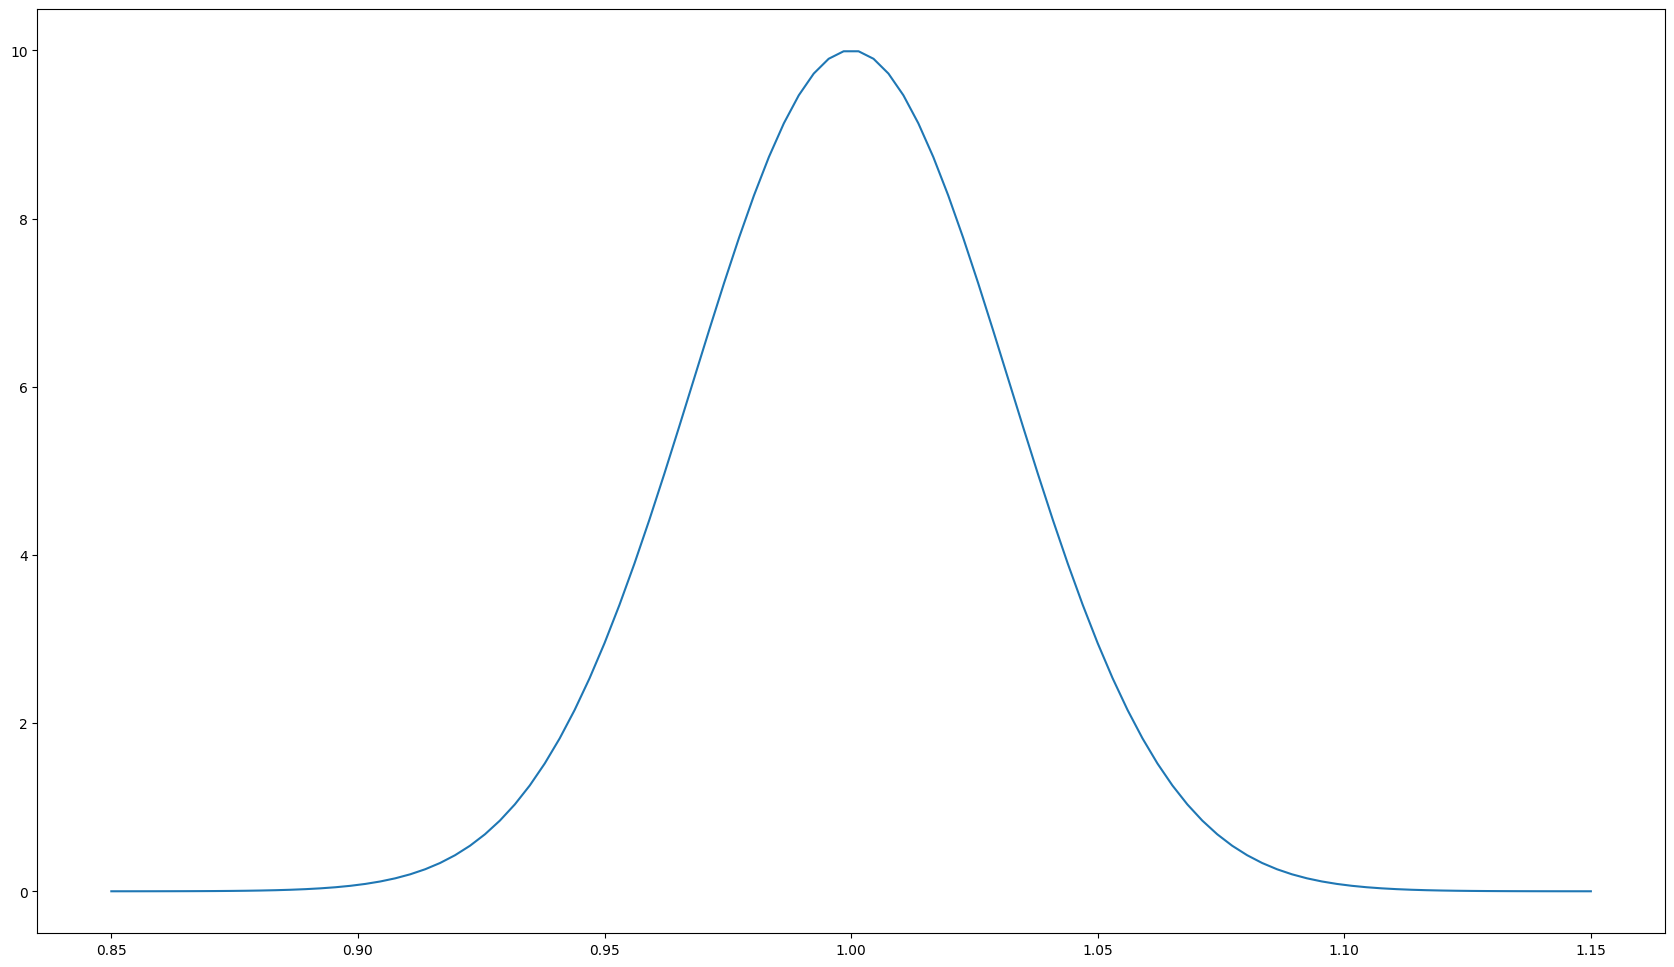

In [33]:
x = np.linspace(vm_space.low, vm_space.high, 100)
low, high = vm_space.low[0], vm_space.high[0]
y = normal_distribution_pdf(
    x=x,
    mu=1.0,
    sigma=0.032,
    c=0.0,
    a=10.0
)
plt.figure(figsize=(21, 12))
plt.plot(x, y)

## Voltage Band Violation Objective

Our usual default is a inversed Gauss-shaped curve that provides incentives for either under- or overvoltage. In order to plot it, we create a number of `RewardInformation` objects corresponding to valid voltage ranges.

In [34]:
vbv_objective = attack_paper.objective.VoltageBandViolationObjective(params={})

In [35]:
vm_rewards = [
    RewardInformation(reward_value=v, observation_space=vm_space, reward_id="vm_pu")
    for v in np.arange(low, high, 0.01)
]

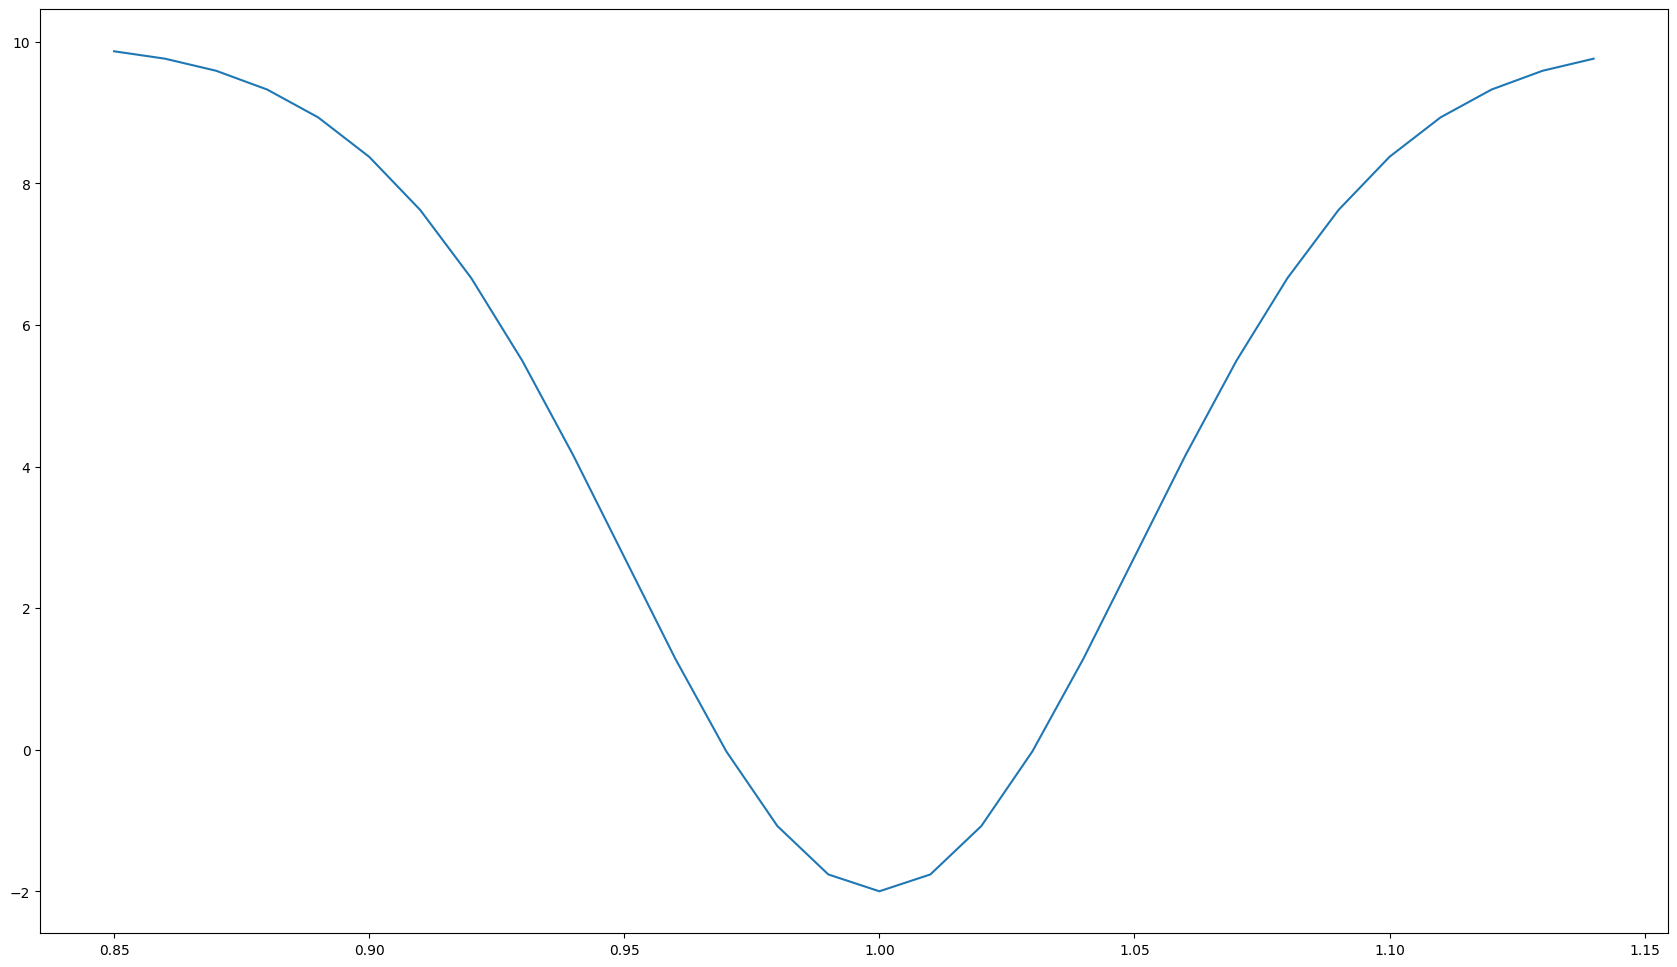

In [36]:
vbv_internal_rewards = [
    vbv_objective.internal_reward([r]) for r in vm_rewards
]
plt.figure(figsize=(21, 12))
plt.plot(
    [ r() for r in vm_rewards ],
    vbv_internal_rewards
)

## Alternating Internal Objective

The idea is that subsequent actions should implement some sort of “pendulum,” meaning that an action in one extreme should be followed by actions towards the other extreme. That is done by describing the desired state in the voltage band. Since we want the attacker to swing from one extreme to the other, we incentivize this based on the current voltage.

We will still use a variant of the Gaussian reward plot, albeit with a little niche notation implicitly added to it. By adding another distribution, we will make it less desirable for an agent to try the same action again.

Let us provide a `Box` whose upper and lower boundaries provide the extremes.

These constants define the shape of our resulting PDF plot. They also serve as parameters for the other PDF that we'll use:

In [37]:
MU = 0.0
SIGMA = 0.05
C = 1.0
A = 10

In [38]:
x = np.linspace(vm_space.low, vm_space.high, 100)
prev_vm_pu = None

def plot_internal_reward(vm_pu):
    low, high = vm_space.low[0], vm_space.high[0]
    y = normal_distribution_pdf(
        x=x,
        mu=max(low, min(vm_pu - 0.15, high - 0.15)),
        sigma=SIGMA,
        c=C,
        a=A
    )
    y += normal_distribution_pdf(
        x=x,
        mu=min(high, max(vm_pu + 0.15, low + 0.15)),
        sigma=SIGMA,
        c=C,
        a=A
    )
    y += normal_distribution_pdf(
        x=x,
        mu=low - abs(vm_pu - low) + 0.001,
        sigma=0.01,
        c=C,
        a=-A
    )
    y += normal_distribution_pdf(
        x=x,
        mu=high + abs(vm_pu - high) - 0.001,
        sigma=0.01,
        c=C,
        a=-1.5*A
    )
    prev_vm_pu = vm_pu
    plt.subplots(figsize=(21, 12))
    plt.plot(x, y)
    plt.axvline(x=vm_pu, ls="--", color="k")

In [39]:
ipywidgets.interact(plot_internal_reward, vm_pu=(vm_space.low[0], vm_space.high[0], 0.01))

interactive(children=(FloatSlider(value=0.8500000238418579, description='vm_pu', max=1.149999976158142, min=0.…

<function __main__.plot_internal_reward(vm_pu)>

Let's see how a static plot over the available voltage range looks like:

In [16]:
vbv_pendulum = attack_paper.objective.VoltageBandViolationPendulum(params={})

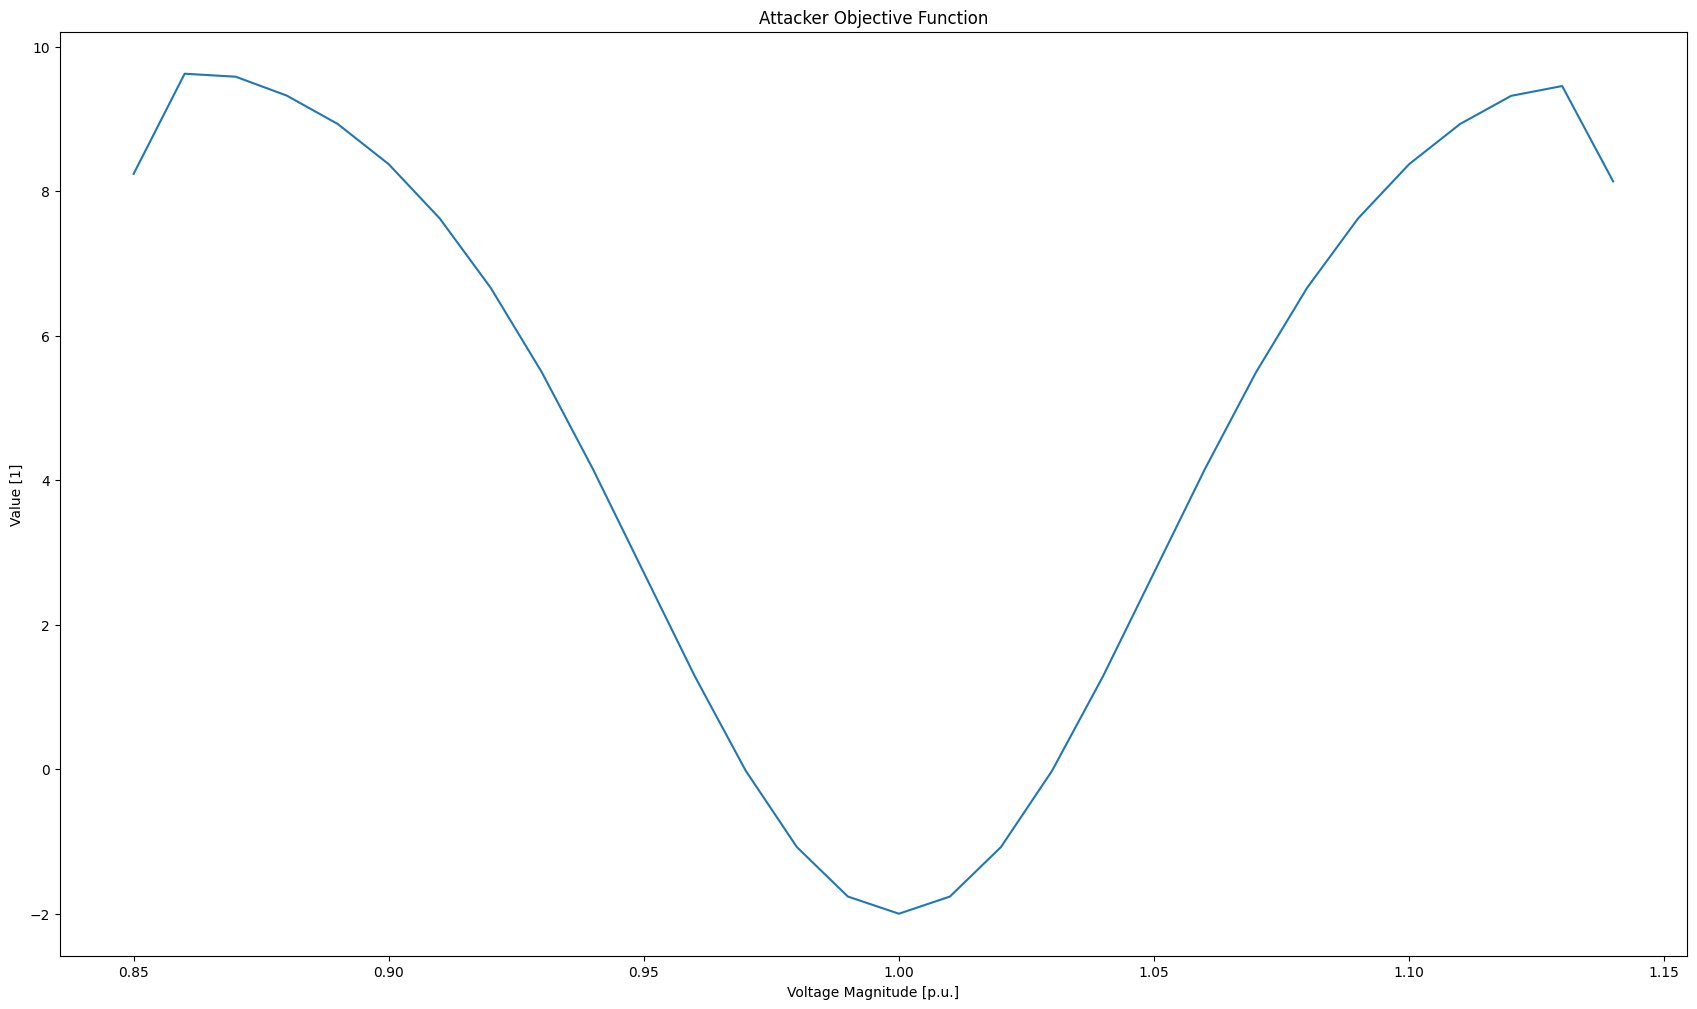

In [24]:
vbvp_internal_rewards = [
    vbv_pendulum.internal_reward([r]) for r in vm_rewards
]
plt.figure(figsize=(21, 12))
plt.title("Attacker Objective Function")
plt.xlabel("Voltage Magnitude [p.u.]")
plt.ylabel("Value [1]")
fig = plt.plot(
    [ r() for r in vm_rewards ],
    vbvp_internal_rewards
)
plt.savefig('attacker-objective.pdf')
fig

## Possible Defender Objective

In [74]:
stages = [
    "Nominal",
    "High",
    "Low"
]

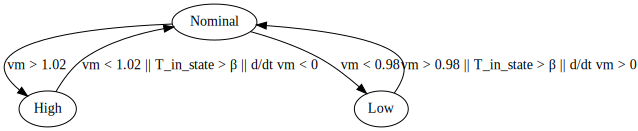

In [154]:
dot = graphviz.Digraph('defender-objective-sm', comment='Defender Objective State Machine')  
for stage in stages:
    dot.node(stage)

dot.edge("Nominal", "High", label="vm > 1.02")
dot.edge("Nominal", "Low", label="vm < 0.98")
dot.edge("High", "Nominal", label="vm < 1.02 || T_in_state > β || d/dt vm < 0")
dot.edge("Low", "Nominal", label="vm > 0.98 || T_in_state > β || d/dt vm > 0")

dot

In [156]:
stage_params = {
    "Nominal": {
        "mu": 1.0,
        "sigma": 0.12,
        "c": 0.0,
        "a": 10.0,
    },
    "High": {
        "mu": 1.0,
        "sigma": 0.032,
        "c": 0.0,
        "a": 10.0,
    },
    "Low": {
        "mu": 1.0,
        "sigma": 0.032,
        "c": 0.0,
        "a": 10.0,
    }
}

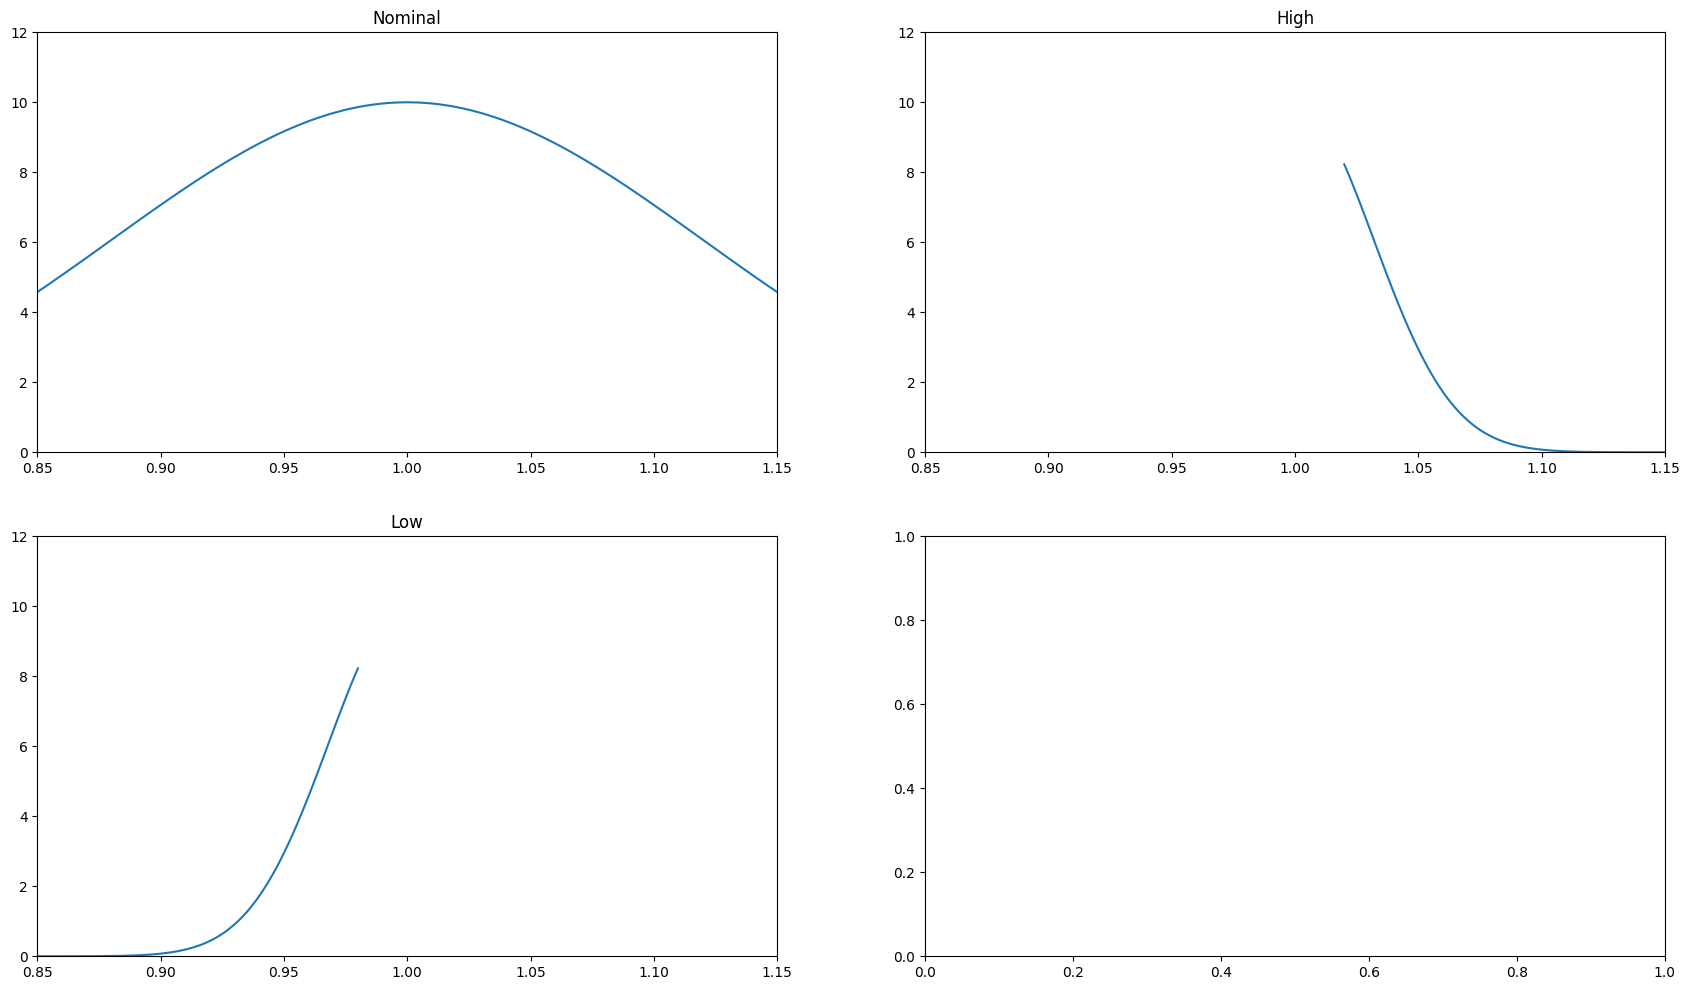

In [157]:
def plot_defender_objective(vm_pu, stage, ax):
    low, high = vm_space.low[0], vm_space.high[0]
    params = stage_params[stage]
    y = normal_distribution_pdf(
        x=vm_pu,
        **params
    )
    ax.plot(x, y)
    ax.set_title(stage)
    ax.set_xlim([0.85, 1.15])
    ax.set_ylim([0.0, 12.0])
    #ax.axvline(x=vm_pu, ls="--", color="k")

fig, axs = plt.subplots(2, 2, figsize=(21, 12))
for stage, ax in zip(stages, axs.reshape(-1)):
    x = np.linspace(vm_space.low, vm_space.high, 100)
    if stage == "Low":
        x = np.linspace(vm_space.low, 0.98, 100)
    if stage == "High":
        x = np.linspace(1.02, vm_space.high, 100)
    plot_defender_objective(x, stage, ax)